In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

In [36]:
# The Fish Data Set
# See example 2 from https://stats.idre.ucla.edu/r/dae/zip/ 
#"nofish","livebait","camper","persons","child","xb","zg","count"
import os
from urllib.request import urlretrieve
if not os.path.isfile('fishing.npz'):
    print("Downloading")
    urlretrieve('http://www-home.htwg-konstanz.de/~oduerr/data/fishing.npz',filename = 'fishing.npz')
d = np.load('fishing.npz')
Xt = d['Xt'] #"livebait","camper","persons","child"
Xte = d['Xte']
yt = d['yt']
yte = d['yte']
pd.DataFrame(Xt[0:2])

,0,1,2,3
0,1.0,0.0,4.0,0.0
1,1.0,1.0,2.0,0.0


In [64]:
########### 1a Linear Regression by Hand #############

# insert intercept
num_rows = Xt.shape[0]
ones_column = np.ones((num_rows, 1), dtype=np.float64)
Xt_intercept = np.hstack((ones_column, Xt))
print("Xt with intercept:")
print("Shape: ", Xt_intercept.shape)
print(Xt_intercept[0:2])

XTX = np.matmul(Xt_intercept.T,Xt_intercept)
XTXI = np.linalg.inv(XTX)
XTXIXT = np.matmul(XTXI, Xt_intercept.T)
w = np.matmul(XTXIXT,yt)

# Show the found weights
print("\nSolution of regression by hand: ")
print(w)

Shape of Xt with intercept:  (200, 5)
[[1. 1. 0. 4. 0.]
 [1. 1. 1. 2. 0.]]

Solution of regression by hand: 
[-8.49222821  2.4822138   2.95430727  4.64953914 -5.47160051]


In [52]:
########### 1b Linear Regression with scikit #############

from sklearn.linear_model import LinearRegression
Xa = np.asarray(Xt_intercept)
ya = np.asarray(yt)
model_skl = LinearRegression(fit_intercept=False) #We have an extended X
model_skl.fit(Xa,ya)
print("Solution of regression by hand: ")
print(model_skl.coef_)

Solution of regression by hand: 
[-8.49222821  2.4822138   2.95430727  4.64953914 -5.47160051]


In [66]:
########### 1c RMSE and NLL #############

num_rows = Xte.shape[0]
ones_column = np.ones((num_rows, 1), dtype=np.float64)
Xte_intercept = np.hstack((ones_column, Xte))
print("Xte with intercept:")
print("Shape: ", Xte_intercept.shape)
print(Xte_intercept[0:2])

yte_pred = np.matmul(Xte_intercept, w)


MSE = np.mean((yte_pred - yte)**2)
RMSE = np.sqrt(MSE)
variance = MSE
NLL = 0.5 * np.log(2 * np.pi * variance) + 0.5 * np.mean((yte_pred - yte)**2) / variance

print("\nRMSE: ", RMSE)
print("Variance: ", variance)
print("NLL: ", NLL)

Shape of Xte with intercept:  (50, 5)
[[1. 0. 0. 3. 0.]
 [1. 1. 0. 3. 1.]]

RMSE:  8.588126386734231
Variance:  73.75591483452077
NLL:  3.5693191297796893


Mean True:  3.06
Mean Pred:  3.584986890619827


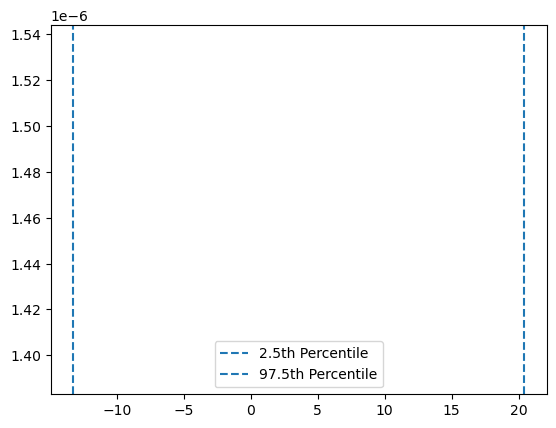

In [67]:
########### 1d Gaussian Plot #############
from scipy.stats import norm

# Compute mean of pred and real
mean_true = np.mean(yte)
mean_pred = np.mean(yte_pred)
print("Mean True: ", mean_true)
print("Mean Pred: ", mean_pred)

percentile025 = mean_pred - 1.96 * RMSE
percentile975 = mean_pred + 1.96 * RMSE

# plot real fish
# plt.plot(norm.pdf(mean_true, RMSE))
# plt.axvline(x=percentile025, linestyle='--', label='2.5th Percentile')
# plt.axvline(x=percentile975, linestyle='--', label='97.5th Percentile')

# plot predicted fish
plt.plot(norm.pdf(mean_pred, RMSE))
plt.axvline(x=percentile025, linestyle='--', label='2.5th Percentile')
plt.axvline(x=percentile975, linestyle='--', label='97.5th Percentile')

plt.legend()
plt.show()

In [72]:
########### 1e Gradient Descent #############
import tensorflow as tf
#import tensorflow_probability as tfp

# k = ??
# p_k = np.exp(-mean_true) * ((mean_true**k) / np.prod(np.arange(1, k + 1)))




Xs = tf.Variable(np.asmatrix(Xt_intercept,dtype='float32'))
ws = tf.Variable((1.,1.,1.,1))
print(Xs.shape)
print(ws.shape)
#ws = tf.Variable(np.asarray(w,dtype='float32'))
for i in range(5000):
    with tf.GradientTape() as tape: #Mechanism to store gradients
        y_hat = tf.matmul(Xs,ws)
        loss = tf.reduce_logsumexp((yt - y_hat)**2) #MSE
        if i % 500 == 0:
            print(i, "  ",ws.numpy().T,'  ',loss.numpy())
        grads = tape.gradient(loss, ws) #gradient wrt w
        ws = tf.Variable(ws - 0.0001 * grads)
print("grads: ", grads)

ValueError: Can't convert non-rectangular Python sequence to Tensor.

In [73]:
########### 1f Plot with Poison CPD #############
from scipy.stats import poisson

residuals = yte - yte_pred

# Fit the Poisson distribution to the residuals
poisson_params = poisson.fit(residuals)

# Create a range of x values for the plot
x = np.arange(0, np.max(residuals) + 1)

# Calculate the probability mass function (PMF) for the Poisson distribution
pmf = poisson.pmf(x, *poisson_params)

# Calculate percentiles using the Poisson distribution
percentiles = poisson.ppf([0.025, 0.975], *poisson_params)


plt.bar(x, pmf, width=0.8, align='center', label='Poisson PMF')
plt.axvline(x=percentiles[0], linestyle='--', label='2.5th Percentile')
plt.axvline(x=percentiles[1], linestyle='--', label='97.5th Percentile')
plt.legend()
plt.xlabel('Predicted Fish')
plt.ylabel('True fish')

AttributeError: 'poisson_gen' object has no attribute 'fit'